In [1]:
# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Data_project4/'

Mounted at /content/drive


## Data Preprocessing



### Step 1: Read the `loan.csv` data from the `Resources` folder into a Pandas DataFrame.

In [3]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
file_path = Path(f'{path}loan.csv')
loan_data = pd.read_csv(file_path)

# Review the DataFrame
loan_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [4]:
# Drop Loan_ID column

columns_to_delete = ['Loan_ID']

loan_data = loan_data.drop(columns = columns_to_delete)


In [5]:
# Separately transforming the Loan_Status column without using OHE, since it needs to remain in one copy

loan_data['Loan_Status'] = loan_data['Loan_Status'].map({'N': 0, 'Y': 1})

In [6]:
# Split to train and test. Splitting before knn imputing required for fitting imputer on train and fill NaNs using it on test

df_train, df_test = train_test_split(loan_data, test_size=0.2, random_state=1)

In [7]:
# Looking at the missing values
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [8]:
# get categorical and numerical columns
categorical_columns = loan_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = loan_data.select_dtypes(include=['int64', 'float64']).columns



In [9]:
#Impute missing values for continuous data only (LoanAmount, Loan_Amount_Term)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer to the numerical columns
df_train[numerical_columns] = imputer.fit_transform(df_train[numerical_columns])

# apply to test !IMPORTANT! for prevent data leak
df_test[numerical_columns] = imputer.transform(df_test[numerical_columns])



In [10]:
# Looking at the number of unique values ​​of categorical variables; if there are few of them, this allows us to use OHE
for i in categorical_columns:
    print(i, loan_data[i].nunique())

Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
Property_Area 3


In [11]:
# Change all categorical columns to binary using get dummies
clean_train_df = pd.get_dummies(df_train, columns=['Gender','Married','Dependents','Education',
                                                    'Self_Employed','Property_Area'])
clean_test_df = pd.get_dummies(df_test, columns=['Gender','Married','Dependents','Education',
                                                    'Self_Employed','Property_Area'])

In [12]:
clean_train_df

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
291,4400.0,0.0,127.0,360.0,0.0,0.0,False,True,False,True,...,False,True,False,True,False,True,False,False,True,False
507,3583.0,0.0,96.0,360.0,1.0,0.0,False,False,True,False,...,False,False,False,True,False,True,False,False,False,True
328,4333.0,2451.0,110.0,360.0,1.0,0.0,True,False,False,True,...,False,False,False,True,False,True,False,False,False,True
609,2900.0,0.0,71.0,360.0,1.0,1.0,True,False,True,False,...,False,False,False,True,False,True,False,True,False,False
69,4300.0,0.0,136.0,360.0,0.0,0.0,True,False,True,False,...,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,6080.0,2569.0,182.0,360.0,1.0,0.0,False,True,False,True,...,False,False,False,True,False,True,False,True,False,False
144,11757.0,0.0,187.0,180.0,1.0,1.0,False,True,False,True,...,False,True,False,True,False,True,False,False,False,True
72,3500.0,0.0,81.0,300.0,1.0,1.0,False,True,True,False,...,False,False,False,True,False,True,False,False,True,False
235,5500.0,1260.0,170.0,360.0,1.0,1.0,False,True,False,True,...,True,False,False,True,False,True,False,True,False,False


### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [13]:
# Separate the data into labels and features
# Separate the y variable, the labels
y_train = clean_train_df['Loan_Status']
y_test = clean_test_df['Loan_Status']

# Separate the X variable, the features
X_train = clean_train_df.drop('Loan_Status', axis=1)
X_test = clean_test_df.drop('Loan_Status', axis=1)


---

In [14]:
X_train

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
291,4400.0,0.0,127.0,360.0,0.0,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False
507,3583.0,0.0,96.0,360.0,1.0,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True
328,4333.0,2451.0,110.0,360.0,1.0,True,False,False,True,True,False,False,False,True,False,True,False,False,False,True
609,2900.0,0.0,71.0,360.0,1.0,True,False,True,False,True,False,False,False,True,False,True,False,True,False,False
69,4300.0,0.0,136.0,360.0,0.0,True,False,True,False,True,False,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,6080.0,2569.0,182.0,360.0,1.0,False,True,False,True,True,False,False,False,True,False,True,False,True,False,False
144,11757.0,0.0,187.0,180.0,1.0,False,True,False,True,False,False,True,False,True,False,True,False,False,False,True
72,3500.0,0.0,81.0,300.0,1.0,False,True,True,False,True,False,False,False,True,False,True,False,False,True,False
235,5500.0,1260.0,170.0,360.0,1.0,False,True,False,True,False,True,False,False,True,False,True,False,True,False,False


## Create a Logistic Regression Model with the Clean Data

In [27]:
# Initiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_model = LogisticRegression(random_state=1)

# Fit the model using training data
logistic_model.fit(X_train, y_train)


LogisticRegression(random_state=1)

In [17]:
# Make a prediction using the testing data
y_pred = logistic_model.predict(X_test)

### Evaluate the model’s performance by doing the following:

* Generate a confusion matrix.

* Print the classification report.

In [18]:
# Generate a confusion matrix for the model
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[16 23]
 [ 2 82]]


In [19]:
# Print the classification report for the model
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.41      0.56        39
         1.0       0.78      0.98      0.87        84

    accuracy                           0.80       123
   macro avg       0.83      0.69      0.71       123
weighted avg       0.82      0.80      0.77       123



In [28]:
# Adding polynomial features so the model can be trained better on a larger set of features.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit logistic regression with L1 regularisation to select only necessary features
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state=1, C=10, penalty='l1', solver='liblinear')
logistic_model.fit(X_train_poly, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_poly)

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.51      0.60        39
         1.0       0.80      0.90      0.85        84

    accuracy                           0.78       123
   macro avg       0.76      0.71      0.72       123
weighted avg       0.77      0.78      0.77       123



### Answer the following question:

---

## Create a Neural Network Model with the Clean Data

In [20]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [47]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

nn_model = tf.keras.models.Sequential()

# First hidden layer
nn_model.add(tf.keras.layers.Dense(units=15, activation="relu", input_dim=20))
nn_model.add(Dropout(0.5))

# Second hidden layer
nn_model.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model.add(Dropout(0.5))

# Output layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 15)                315       
                                                                 
 dropout_10 (Dropout)        (None, 15)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                160       
                                                                 
 dropout_11 (Dropout)        (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
Total params: 486 (1.90 KB)
Trainable params: 486 (1.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
fit_model = nn_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
16/16 [==============================] - 2s 4ms/step - loss: 1.3852 - accuracy: 0.3870
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 1.0987 - accuracy: 0.4257
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0889 - accuracy: 0.4318
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0463 - accuracy: 0.4481
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9141 - accuracy: 0.4949
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8477 - accuracy: 0.5255
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8128 - accuracy: 0.5336
Epoch 8/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7809 - accuracy: 0.5642
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.7038 - accuracy: 0.6069
Epoch 10/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.6090
Epoch 11/

In [50]:
model_loss, model_accuracy = nn_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

4/4 - 1s - loss: 0.4930 - accuracy: 0.8049 - 519ms/epoch - 130ms/step
Loss: 0.49300020933151245, Accuracy: 0.8048780560493469


In [21]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the neural network model
# The first dense layer with 64 neurons and ReLU (Rectified Linear Unit) activation function:
# The ReLU function is often used in hidden layers because it helps the model learn nonlinear relationships in the data and prevents the vanishing gradient problem.
# Dropout layer with a rate of 0.5: Dropout is used to prevent overfitting by randomly disabling neurons during training.
# A rate of 0.5 means that 50% of the neurons will be disabled at each training iteration.
# The second dense layer with 32 neurons and ReLU activation function: This layer helps the model learn more complex patterns in the data.
# Another Dropout layer with a rate of 0.5: For additional overfitting prevention.
# Output layer with 1 neuron and sigmoid activation function: Since the task is binary classification (Loan_Status - approved or not),
# the output layer with a sigmoid activation function returns a probability value (from 0 to 1), which is easily interpreted as the probability of the positive class.

neural_network_model = Sequential()
neural_network_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(32, activation='relu'))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
neural_network_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
neural_network_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluating the model on test data
loss, accuracy = neural_network_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/50
13/13 [==============================] - 1s 23ms/step - loss: 0.7902 - accuracy: 0.5153 - val_loss: 0.7025 - val_accuracy: 0.5354
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.7051 - accuracy: 0.5791 - val_loss: 0.6495 - val_accuracy: 0.6869
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.6623 - accuracy: 0.6454 - val_loss: 0.6245 - val_accuracy: 0.7172
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.6309 - accuracy: 0.6760 - val_loss: 0.6077 - val_accuracy: 0.7172
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.6660 - accuracy: 0.6403 - val_loss: 0.5932 - val_accuracy: 0.7273
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6131 - accuracy: 0.6786 - val_loss: 0.5805 - val_accuracy: 0.7273
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.5922 - accuracy: 0.6862 - val_loss: 0.5712 - val_accuracy: 0.7374
Epoch 8/50
13/13 [=

In [22]:
# Improving the neural network model
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating the neural network model
# The first dense layer with 64 neurons and ReLU (Rectified Linear Unit) activation function:
# The ReLU function is often used in hidden layers because it helps the model learn nonlinear relationships in the data and prevents the vanishing gradient problem.
# Dropout layer with a rate of 0.5: Dropout is used to prevent overfitting by randomly disabling neurons during training.
# A rate of 0.5 means that 50% of the neurons will be disabled at each training iteration.
# The second dense layer with 32 neurons and ReLU activation function: This layer helps the model learn more complex patterns in the data.
# Another Dropout layer with a rate of 0.5: For additional overfitting prevention.
# Output layer with 1 neuron and sigmoid activation function: Since the task is binary classification (Loan_Status - approved or not),
# the output layer with a sigmoid activation function returns a probability value (from 0 to 1), which is easily interpreted as the probability of the positive class.

neural_network_model = Sequential()
neural_network_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(32, activation='relu'))
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
neural_network_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
neural_network_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluating the model on test data
loss, accuracy = neural_network_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/100
13/13 [==============================] - 1s 22ms/step - loss: 0.7276 - accuracy: 0.5714 - val_loss: 0.6593 - val_accuracy: 0.6465
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.7093 - accuracy: 0.6276 - val_loss: 0.6340 - val_accuracy: 0.6667
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.6730 - accuracy: 0.6633 - val_loss: 0.6163 - val_accuracy: 0.6869
Epoch 4/100
13/13 [==============================] - 0s 9ms/step - loss: 0.6325 - accuracy: 0.6735 - val_loss: 0.5999 - val_accuracy: 0.6869
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.6298 - accuracy: 0.6811 - val_loss: 0.5883 - val_accuracy: 0.6869
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.6229 - accuracy: 0.6786 - val_loss: 0.5798 - val_accuracy: 0.6970
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5878 - accuracy: 0.7015 - val_loss: 0.5691 - val_accuracy: 0.7071
Epoch 8/100


In [23]:
# Trying to improve the model by using a different optimizer RMSprop

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.regularizers import l2

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating a more complex neural network model
# First dense layer with 256 neurons and ReLU activation function: More neurons to capture more complex patterns.
# BatchNormalization layer to stabilize and accelerate the learning process.
# Dropout layer with a rate of 0.5 to prevent overfitting.
# Second dense layer with 128 neurons and ReLU activation function.
# BatchNormalization layer.
# Dropout layer with a rate of 0.5.
# Third dense layer with 64 neurons and ReLU activation function.
# BatchNormalization layer.
# Dropout layer with a rate of 0.5.
# Fourth dense layer with 32 neurons and ReLU activation function.
# BatchNormalization layer.
# Dropout layer with a rate of 0.5.
# Output layer with 1 neuron and sigmoid activation function: For binary classification, returning a probability value.

neural_network_model = Sequential()
neural_network_model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))
neural_network_model.add(BatchNormalization())
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
neural_network_model.add(BatchNormalization())
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
neural_network_model.add(BatchNormalization())
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
neural_network_model.add(BatchNormalization())
neural_network_model.add(Dropout(0.5))
neural_network_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
neural_network_model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
neural_network_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.15)

# Evaluating the model on test data
loss, accuracy = neural_network_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')


Epoch 1/50
7/7 [==============================] - 3s 55ms/step - loss: 1.3143 - accuracy: 0.5324 - val_loss: 1.0074 - val_accuracy: 0.5811
Epoch 2/50
7/7 [==============================] - 0s 10ms/step - loss: 1.3569 - accuracy: 0.5659 - val_loss: 1.0103 - val_accuracy: 0.5541
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 1.3167 - accuracy: 0.5444 - val_loss: 1.0122 - val_accuracy: 0.5946
Epoch 4/50
7/7 [==============================] - 0s 13ms/step - loss: 1.2562 - accuracy: 0.5564 - val_loss: 1.0126 - val_accuracy: 0.5405
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 1.2411 - accuracy: 0.5755 - val_loss: 1.0127 - val_accuracy: 0.5946
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 1.2080 - accuracy: 0.5396 - val_loss: 1.0086 - val_accuracy: 0.6216
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 1.2011 - accuracy: 0.5492 - val_loss: 1.0041 - val_accuracy: 0.6892
Epoch 8/50
7/7 [===========

In [25]:
accuracy

0.8130081295967102

### Answer the following question:

## Create a KNN Model with the Clean Data

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb



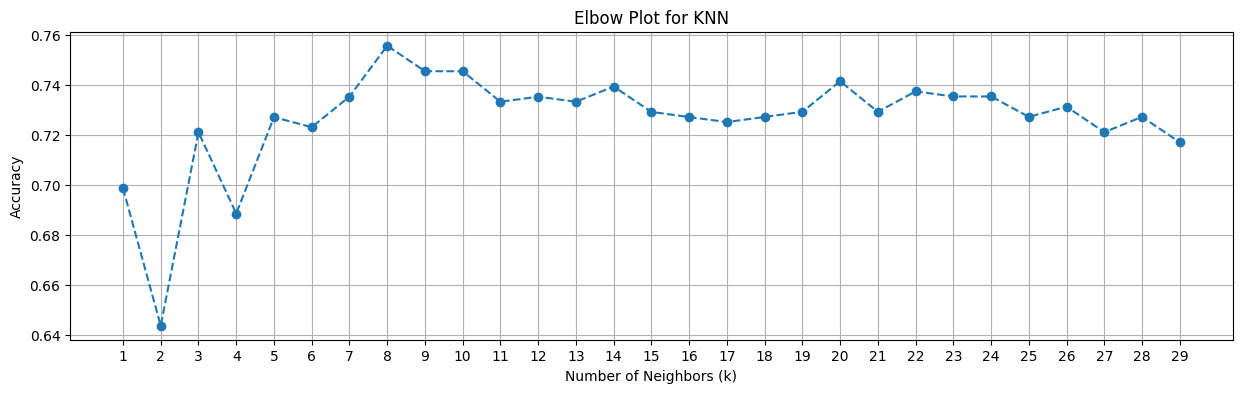

In [38]:
# iterate through data and find best k_value
k_values = list(range(1, 30))
accuracy_scores = []

for i in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn_model, X_train, y_train, cv=5)
    accuracy_scores.append(score.mean())

# Plot results to visualize highest accuracy k value
plt.figure(figsize=(15, 4))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Elbow Plot for KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()

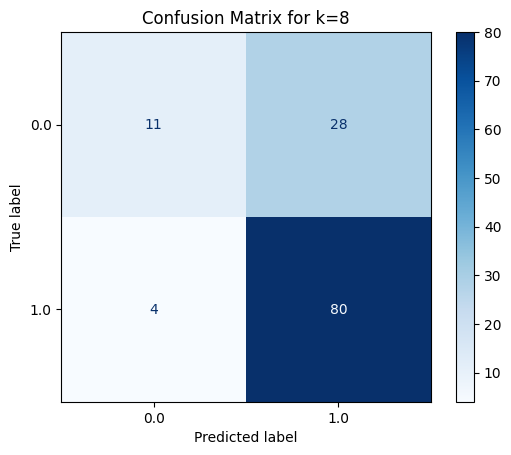

In [36]:
best_k = 8
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

# make predictions
y_pred = knn_model.predict(X_test)

# evaluate performance with confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=y_train.unique())

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for k={best_k}')
plt.show()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}


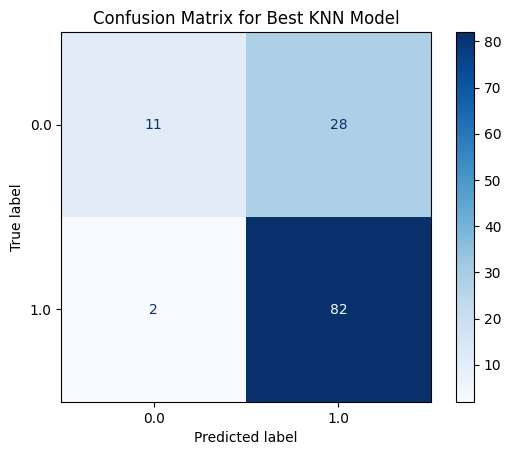

              precision    recall  f1-score   support

         0.0       0.85      0.28      0.42        39
         1.0       0.75      0.98      0.85        84

    accuracy                           0.76       123
   macro avg       0.80      0.63      0.63       123
weighted avg       0.78      0.76      0.71       123



In [40]:
# Model optimization using grid search

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),  # Range of k values
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# initiate new model
knn_2 = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_2, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model with the best parameters
best_knn = grid_search.best_estimator_

# Make predictions
y_pred = best_knn.predict(X_test)

# Generate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=y_train.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_train.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Best KNN Model')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))

### Answer the following question:

## Create a gradient boosting model with the Clean Data

[LightGBM] [Info] Number of positive: 338, number of negative: 153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 416
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.688391 -> initscore=0.792608
[LightGBM] [Info] Start training from score 0.792608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

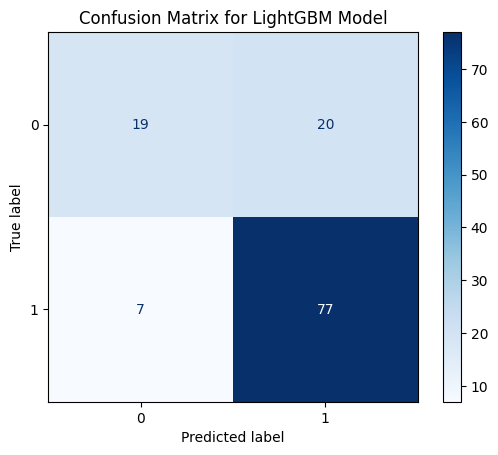

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.49      0.58        39
         1.0       0.79      0.92      0.85        84

    accuracy                           0.78       123
   macro avg       0.76      0.70      0.72       123
weighted avg       0.77      0.78      0.77       123



In [42]:
# Build LGBClassifier

# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

### Answer the following question:

## Create Random Forest Model on Clean Data

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train, y_train)


# Make predictions using the testing data
predictions = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7642


In [55]:
# Evaluate the model

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculate the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [56]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,17,22
Actual 1,7,77


Accuracy Score : 0.7642276422764228
Classification Report
              precision    recall  f1-score   support

         0.0       0.71      0.44      0.54        39
         1.0       0.78      0.92      0.84        84

    accuracy                           0.76       123
   macro avg       0.74      0.68      0.69       123
weighted avg       0.76      0.76      0.75       123



In [59]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, df_train.columns), reverse=True)

[(0.2564602812411606, 'Self_Employed'),
 (0.1763575136240379, 'Gender'),
 (0.17222962012796217, 'Dependents'),
 (0.10662039966721842, 'Married'),
 (0.04766671483887428, 'Education'),
 (0.019932562359057972, 'Credit_History'),
 (0.018154403116100466, 'Property_Area'),
 (0.017094134226435437, 'LoanAmount'),
 (0.014994825834838531, 'Loan_Amount_Term'),
 (0.014764189167054912, 'ApplicantIncome'),
 (0.014442905917112094, 'CoapplicantIncome'),
 (0.013050620200614656, 'Loan_Status')]

['Self_Employed' 'Gender' 'Dependents' 'Married' 'Education'
 'Credit_History' 'Property_Area' 'LoanAmount' 'Loan_Amount_Term'
 'ApplicantIncome' 'CoapplicantIncome' 'Loan_Status']


<Figure size 1200x1000 with 0 Axes>

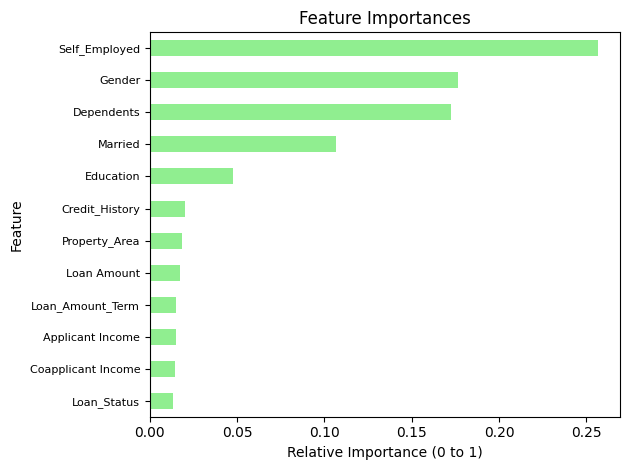

In [60]:
importances = rf_model.feature_importances_
features = df_train.columns

# We can sort the features by their importance
sorted_importances = sorted(zip(importances, features), reverse=True)

# Create the DataFrame
importances_df = pd.DataFrame(sorted_importances, columns=['Importance', 'Feature'])

# Print unique feature names (for debugging purposes)
print(importances_df['Feature'].unique())

# Create a complete mapping dictionary for all features
feature_name_mapping = {
    'Credit_History_0.0': 'Credit History 0',
    'Credit_History_1.0': 'Credit History 1',
    'ApplicantIncome': 'Applicant Income',
    'LoanAmount': 'Loan Amount',
    'CoapplicantIncome': 'Coapplicant Income',
    'ApplicantIncome_bins': 'Applicant Income Bins',
    'LoanAmount_bins': 'Loan Amount Bins',
    'CoapplicantIncome_bins': 'Coapplicant Income Bins',
    'Property_Area_Semiurban': 'Property Area Semiurban',
    'Property_Area_Rural': 'Property Area Rural',
    'Dependents_0': 'Dependents 0',
    'Property_Area_Urban': 'Property Area Urban',
    'Dependents_1': 'Dependents 1',
    'Self_Employed_No': 'Self Employed No',
    'Education_Graduate': 'Education Graduate',
    'Married_No': 'Married No',
    'Education_Not Graduate': 'Education Not Graduate',
    'Married_Yes': 'Married Yes',
    'Gender_Male': 'Gender Male',
    'Dependents_2': 'Dependents 2',
    'Gender_Female': 'Gender Female',
    'Self_Employed_Yes': 'Self Employed Yes',
    'Loan_Amount_Term_360': 'Loan Term 360',
    'Dependents_3+': 'Dependents 3+',
    'Loan_Amount_Term_180': 'Loan Term 180',
    'Loan_Amount_Term_480': 'Loan Term 480',
    'Loan_Amount_Term_300': 'Loan Term 300',
    'Loan_Amount_Term_240': 'Loan Term 240',
    'Loan_Amount_Term_348': 'Loan Term 348',
    'Loan_Amount_Term_295': 'Loan Term 295',
    'Loan_Amount_Term_84': 'Loan Term 84',
    'Loan_Amount_Term_324': 'Loan Term 324',
    'Loan_Amount_Term_120': 'Loan Term 120',
    'Loan_Amount_Term_60': 'Loan Term 60',
    'Loan_Amount_Term_312': 'Loan Term 312',
    'Loan_Amount_Term_288': 'Loan Term 288',
    'Loan_Amount_Term_384': 'Loan Term 384',
    'Loan_Amount_Term_36': 'Loan Term 36',
    'Loan_Amount_Term_12': 'Loan Term 12'
}

# Replace feature names with cleaned-up names, handle missing keys
importances_df['Feature'] = importances_df['Feature'].map(feature_name_mapping).fillna(importances_df['Feature'])

# Set the cleaned-up feature names as the index
importances_df.set_index('Feature', inplace=True)

# Sort values by importance
importances_sorted = importances_df.sort_values(by='Importance')

# Adjust the figure size
plt.figure(figsize=(12, 10))  # Increase the height to give more space for the y-axis labels

# Plot the bar chart
ax = importances_sorted.plot(kind='barh', color='lightgreen', title='Feature Importances', legend=False)

# Make the font size of the y-axis tick labels smaller
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Adjust the fontsize as needed

# Label the x-axis
ax.set_xlabel('Relative Importance (0 to 1)')  # Label the x-axis with the appropriate units

# Adjust layout to make room for the labels
plt.tight_layout()

# Save the plot as a JPG file
plt.savefig('feature_importances.jpg')

plt.show()

In [24]:
import joblib

# Save the logistic regression model
joblib.dump(logistic_model, 'logistic_model.pkl')

# Save the neural network model
neural_network_model.save('neural_network_model.h5')

# Save the KNN model
joblib.dump(knn_model, 'knn_model.pkl')

# Save the LightGBM model
joblib.dump(lgb_model, 'lgb_model.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://8kv9fhg4u5u-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [26]:
from flask import Flask, request, jsonify, render_template
import joblib
import numpy as np
from tensorflow.keras.models import load_model

# Initialize the Flask application
app = Flask(__name__, template_folder='/content/drive/MyDrive/templates')

# Load the models
logistic_model = joblib.load('logistic_model.pkl')
neural_network_model = load_model('neural_network_model.h5')

# Main page route
@app.route('/')
def home():
    return render_template('Index.html')

# API for logistic regression prediction
@app.route('/predict_logistic', methods=['POST'])
def predict_logistic():
    data = request.get_json(force=True)
    X = np.array([data['features']])
    print(X)
    prediction = logistic_model.predict(np.array([data['features']]))
    output = int(prediction[0])
    return jsonify(result=output)

# API for neural network prediction
@app.route('/predict_nn', methods=['POST'])
def predict_nn():
    data = request.get_json(force=True)
    prediction = neural_network_model.predict(np.array([data['features']]))
    output = int(prediction[0][0] > 0.5)
    return jsonify(result=output)

# Run the Flask application
if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
line = '4400.0,	0.0, 127.0, 360.0, 0.0, False, True, False,	True, False, False, True,	False, True, False, True,	False, False, True, False'

#replace all bool by 1 and 0
line = line.replace('False', '0')
line = line.replace('True', '1')
print(line)


4400.0,	0.0, 127.0, 360.0, 0.0, 0, 1, 0,	1, 0, 0, 1,	0, 1, 0, 1,	0, 0, 1, 0


In [ ]:
logistic_model.coef_

array([[-7.73156956e-07, -5.72028274e-05, -8.00448672e-04,
        -5.54008187e-03,  2.89093002e+00,  1.55418855e-01,
        -3.60169345e-02, -1.14273016e-01,  2.30438088e-01,
         1.27940028e-01, -1.94362697e-01,  2.14724229e-01,
         7.15780232e-02,  3.56120796e-01, -1.93402631e-01,
        -7.39305972e-02, -8.85285738e-03, -2.01918106e-01,
         6.82647037e-01, -3.18010769e-01]])

In [ ]:
list(zip(df_train.columns, logistic_model.coef_[0]))

[('Gender', -7.731569558604495e-07),
 ('Married', -5.720282744144973e-05),
 ('Dependents', -0.0008004486715148971),
 ('Education', -0.005540081874714804),
 ('Self_Employed', 2.890930021388891),
 ('ApplicantIncome', 0.15541885543745237),
 ('CoapplicantIncome', -0.03601693447988587),
 ('LoanAmount', -0.11427301630046399),
 ('Loan_Amount_Term', 0.23043808840369423),
 ('Credit_History', 0.1279400276829473),
 ('Property_Area', -0.19436269728650718),
 ('Loan_Status', 0.2147242294506017)]